In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pickle
import numpy as np
from scipy import io

In [3]:
from elephant.statistics import optimal_kernel_bandwidth, instantaneous_rate
from neo.core import SpikeTrain
from quantities import s, ms
from elephant import kernels
import quantities as qu

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
import seaborn as sns
from rgc_natstim_model.constants.plot_settings import cmap_colors

In [5]:
from rgc_natstim_model.analyses.ephys import get_spike_raster, get_rates

In [6]:
from rgc_natstim_model.utils.plot import save_this

# Load data

In [7]:
base_path = r'/gpfs01/euler/data/SharedFiles/projects/Hoefling2024/data/mei/experiment'

In [8]:
example_types = [1, 5, 10,18, 20, 21, 23, 24, 28, 31, 32]

In [9]:
ond = [0, 4, 5, 7]
onalpha = [1, 2, 3, 6]

In [10]:
sorting_idx = np.asarray([0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 9])

### Electrophysiological recordings

In [11]:
raster = io.loadmat(os.path.join(base_path, 'ephys','090222B_raster.mat'))

raster_5 = io.loadmat(os.path.join(base_path, 'ephys', '082622Bc3_raster.mat'))

raster_6_7 = io.loadmat(os.path.join(base_path, 'ephys', '083022Bc8_c9_raster.mat'))

spike_times_by_cell_idx = {}
for cell_idx in range(5):
    spike_times_by_cell_idx[cell_idx] = get_spike_raster(raster, cell_idx)

spike_times_by_cell_idx[5] = get_spike_raster(raster_5, 0)

for i in [6, 7]:
    spike_times_by_cell_idx[i] = get_spike_raster(raster_6_7, i-6)

In [12]:
n_cells_ephys = len(spike_times_by_cell_idx)

### imaging recordings

In [13]:
with open(os.path.join(base_path, 'imaging', 'weighted_resp_by_type.pkl'), "rb") as f:
    weighted_resp_by_type = pickle.load(f)

### Estimate spike rates

In [14]:
kernel = kernels.GaussianKernel(sigma=75*qu.ms)
time_array = np.linspace(-1, 1, num =100) *qu.s

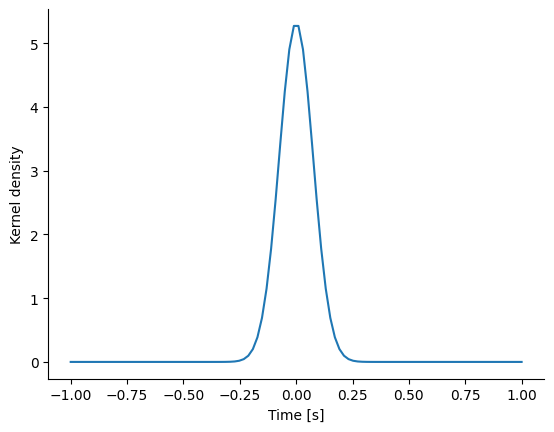

In [15]:
plt.plot(time_array, kernel(time_array))
plt.xlabel('Time [s]')
plt.ylabel('Kernel density')
sns.despine()

In [16]:
trains_by_cell = dict()
rates_by_cell = dict()
z_scored_rates_by_cell = dict()
for cell_idx in range(n_cells_ephys):
    trains_by_cell[cell_idx], rates_by_cell[cell_idx], z_scored_rates_by_cell[cell_idx] = \
    get_rates(spike_times_by_cell_idx[cell_idx], kernel=kernel)

In [17]:
opt_slice = slice(30, 50)

In [18]:
mean_rates_array = np.zeros((n_cells_ephys, 11))
norm_rates_array = np.zeros((n_cells_ephys, 11))
for cell_idx in range(n_cells_ephys):
    mean_rate = np.asarray(
        [z_scored_rates_by_cell[cell_idx][t][:, opt_slice].mean(
            axis=1  # average across time
        ).mean(
            # average across repetitions 
        ) for t in example_types]
    )
    mean_rates_array[cell_idx] = mean_rate

# plot mean rates

In [19]:
from rgc_natstim_model.plotting.ephys import plot_imaging_ephys

In [20]:
plot_path = r'/gpfs01/euler/User/lhoefling/Plots/paper_figs/rebuttal_2/ephys/'

### plot settings

In [21]:
rc_dict_raster = {'figure.dpi': 300,
 'figure.figsize': [3, 2],
 'figure.frameon': False,
 'font.size': 8,
 'lines.linewidth':.5,
 'lines.markersize': 2,
 'lines.markeredgewidth': 0.5,
 'errorbar.capsize': 1,
 'legend.columnspacing': 0.5,
 'legend.frameon': False,
 'legend.markerscale': 0.4,
 'legend.labelspacing': 0.1,
 'legend.handletextpad': 0,
 'legend.loc': 'lower right',
 'axes.labelpad': 1.0,
 'xtick.major.pad': 1,
 'ytick.major.pad': 1}

pdf


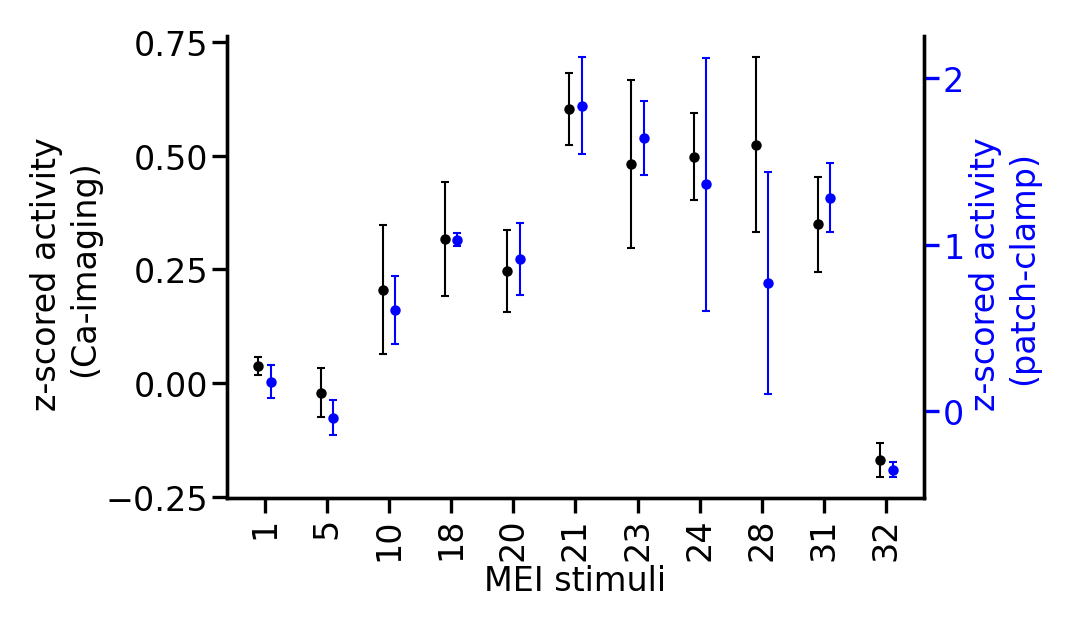

In [22]:
plot_imaging_ephys(weighted_resp_by_type,
                   mean_rates_array,
                   24,
                   sorting_idx,
                   slice(30,50),
                   onalpha,
                   rc_dict_raster,
                   x_offset=.1
                  )
save_this(plot_path, 'g24', svg=False)

pdf


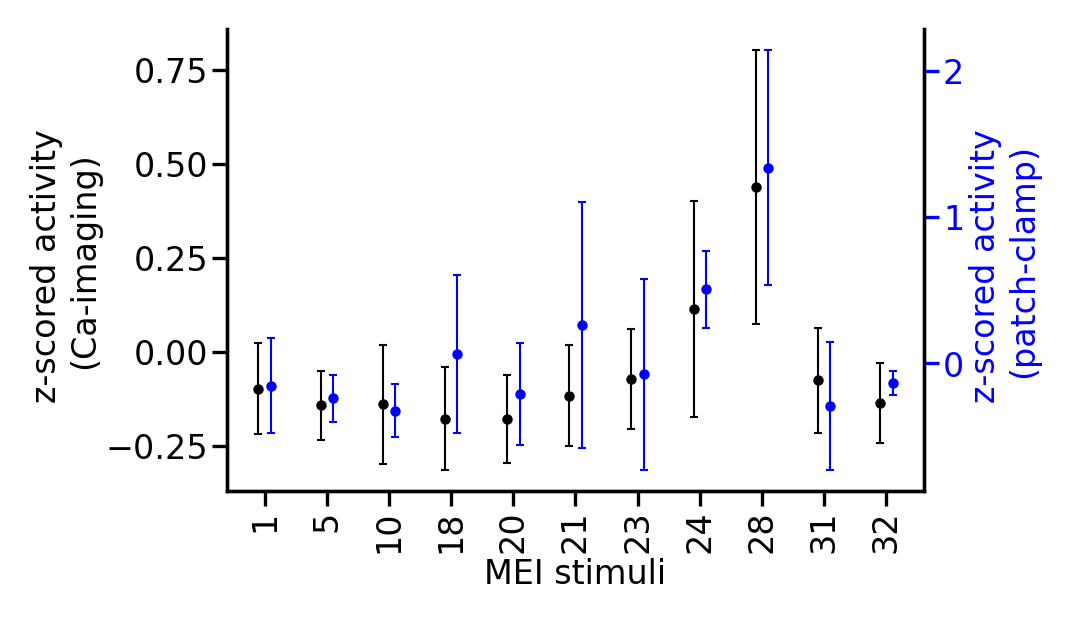

In [23]:
plot_imaging_ephys(weighted_resp_by_type,
                   mean_rates_array,
                   28,
                   sorting_idx,
                   slice(30,50),
                   ond,
                   rc_dict_raster,
                   x_offset=.1
                  )
save_this(plot_path, 'g28', svg=False)

In [24]:
from rgc_natstim_model.plotting.ephys import plot_raster, plot_rate

### raster plots

In [25]:
rc_dict_raster = {'figure.dpi': 300,
 'figure.figsize': [2, 2],
 'figure.frameon': False,
 'font.size': 8,
 'lines.linewidth':.5,
 'lines.markersize': 2,
 'lines.markeredgewidth': 0.5,
 'errorbar.capsize': 1,
 'legend.columnspacing': 0.5,
 'legend.frameon': False,
 'legend.markerscale': 0.4,
 'legend.labelspacing': 0.1,
 'legend.handletextpad': 0,
 'legend.loc': 'lower right',
 'axes.labelpad': 1.0,
 'xtick.major.pad': 1,
 'ytick.major.pad': 1}

pdf
pdf
pdf
pdf


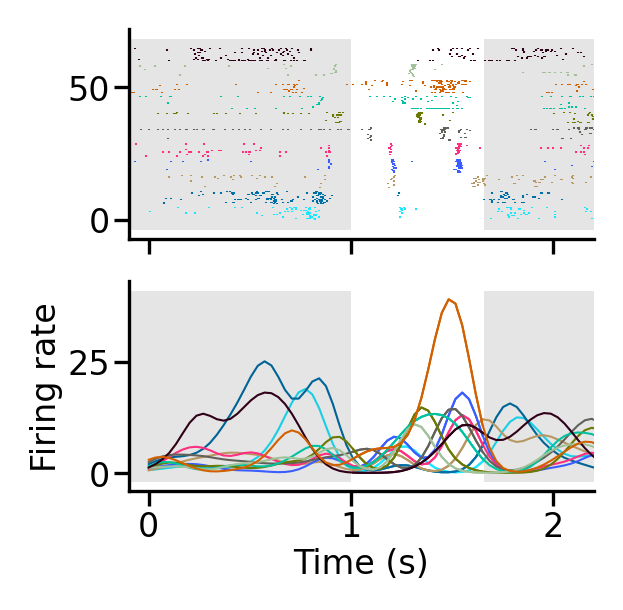

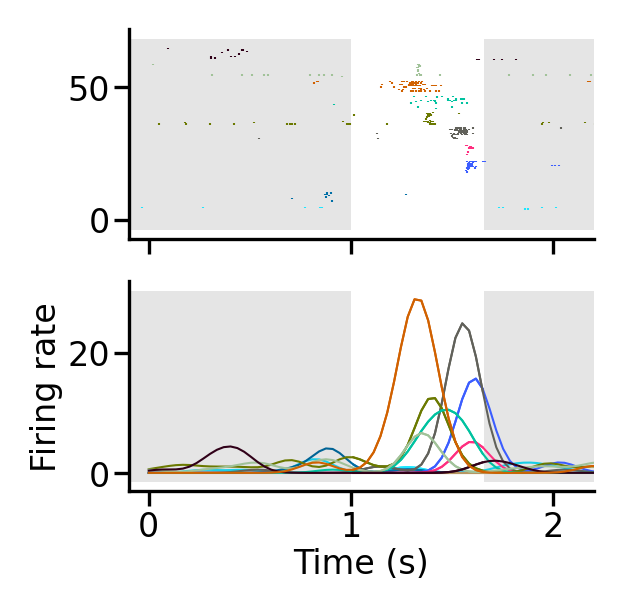

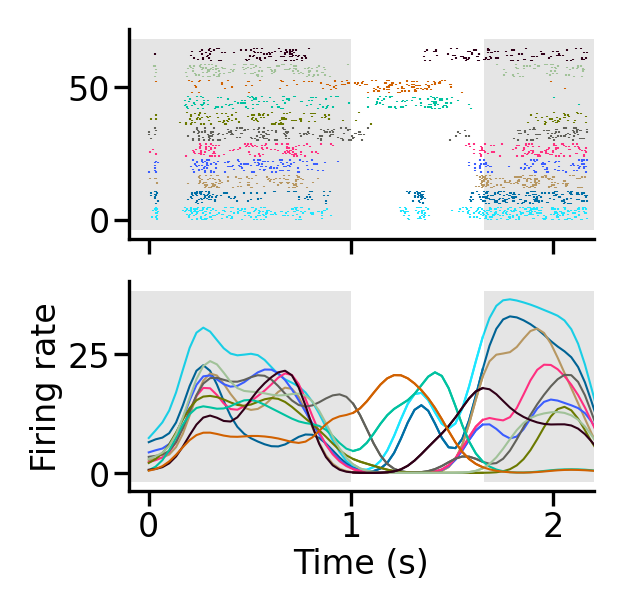

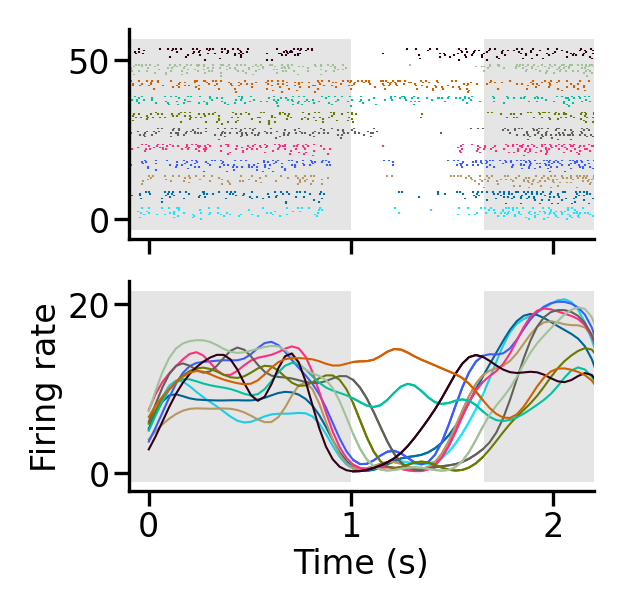

In [26]:
with mpl.rc_context(rc_dict_raster):
    for cell_idx in ond:
        fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True)
        plot_raster(axs[0], 
                    rc_dict_raster, 
                    spike_times_by_cell_idx[cell_idx])
        plot_rate(axs[1], 
                  rc_dict_raster, 
                  rates_by_cell[cell_idx],
                  opt_slice=slice(30,50))
        save_this(os.path.join(plot_path, 'OND/'), f'raster_rate_{cell_idx}', svg=False,transparent=False)

pdf
pdf
pdf
pdf


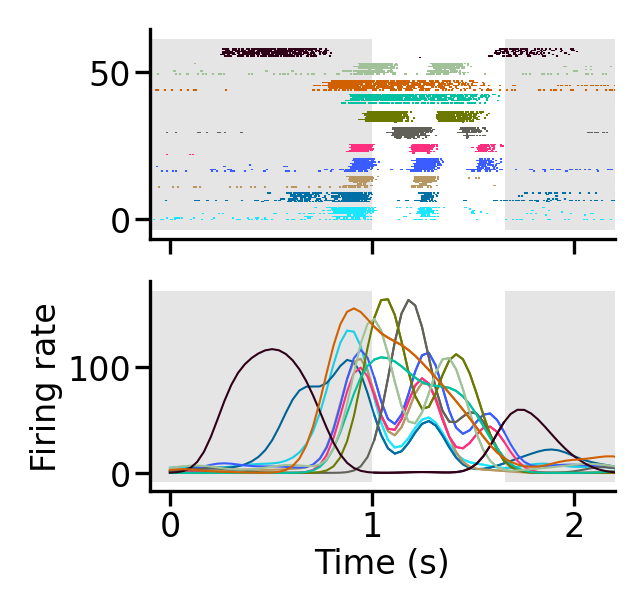

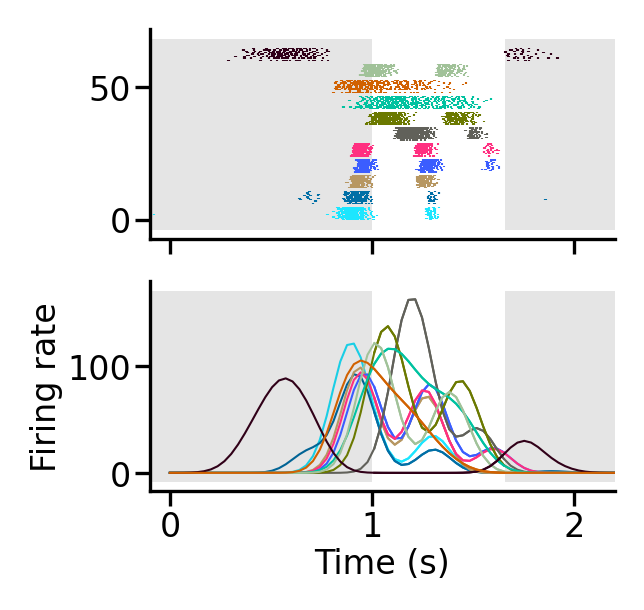

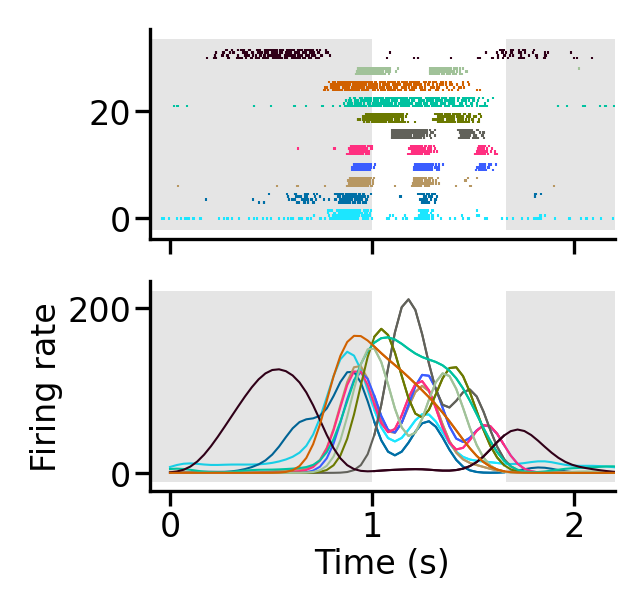

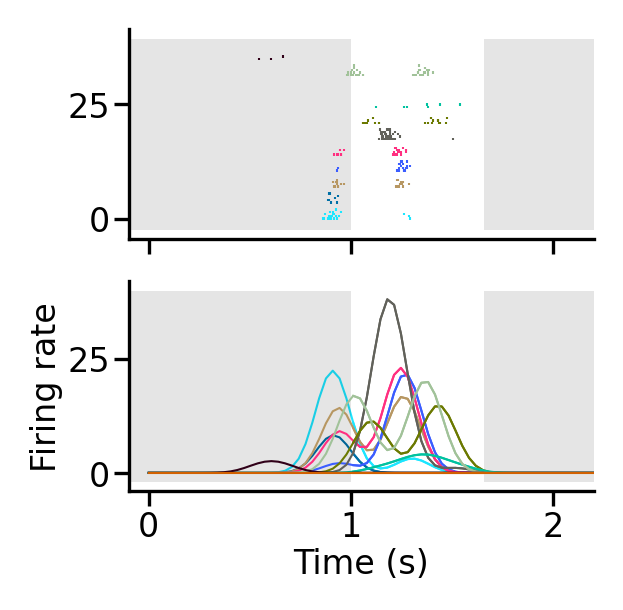

In [27]:
with mpl.rc_context(rc_dict_raster):
    for cell_idx in onalpha:
        fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True)
        plot_raster(axs[0], 
                    rc_dict_raster, 
                    spike_times_by_cell_idx[cell_idx])
        plot_rate(axs[1], 
                  rc_dict_raster, 
                  rates_by_cell[cell_idx],
                  opt_slice=slice(30,50))
        save_this(os.path.join(plot_path, 'On_Alpha/'), f'raster_rate_{cell_idx}', svg=False, transparent=False)